# Audio generation example
#### following https://gist.github.com/naotokui/12df40fa0ea315de53391ddc3e9dc0b9



In [1]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn
from IPython.display import Audio
from pydub import AudioSegment

%matplotlib inline

track_path = 'source/Raingurl.wav'

### if need to convert mp3 -> wav

In [2]:
if track_path.endswith("mp3"):
    track = AudioSegment.from_mp3(track_path)
    track_path = track_path.replace("mp3", "wav")
    track.export(track_path, format="wav")

### now get to work

In [14]:
sample_rate = 64000
y, _ = librosa.load(track_path, sr=sample_rate, mono=True)
print(y.shape)

y = y[500000:780000]

min_y = np.min(y)
max_y = np.max(y)

y = (y - min_y) / (max_y - min_y)
print(y.dtype, min_y, max_y)

Audio(y, rate=sample_rate)

(15183423,)
float32 -1.01437 1.03083


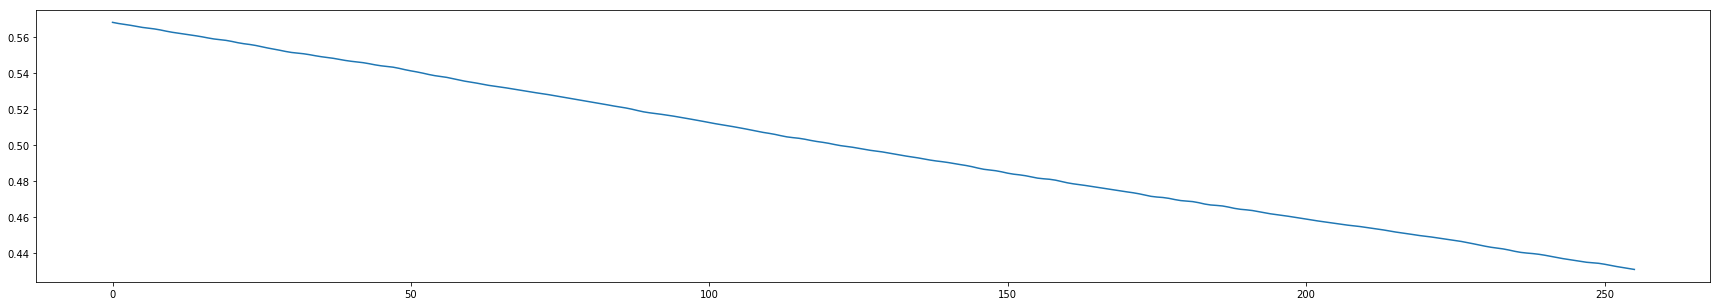

In [15]:
plt.figure(figsize=(30, 5))
plt.plot(y[20000:20256])
plt.show()

### build model

In [16]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # what is this for??

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.layers import Input
from keras.optimizers import RMSprop
import tensorflow as tf

maxlen = 128
nb_output = 256 # resolution - 8-bit encoding
latent_dim = 128

inputs = Input(shape=(maxlen, nb_output))
x = LSTM(latent_dim, return_sequences=True)(inputs)
x = Dropout(0.4)(x)
x = LSTM(latent_dim)(x)
x = Dropout(0.4)(x)
output = Dense(nb_output, activation='softmax')(x)
model = Model(inputs, output)

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [17]:
from tqdm import tqdm

# estimate (0 - 255) based on 256 previous samples
step = 5
next_sample = []
samples = []

for j in tqdm(range(0, y.shape[0] - maxlen, step)):
    seq = y[j: j + maxlen + 1]
    seq_matrix = np.zeros((maxlen, nb_output), dtype=bool)
    for i,s in enumerate(seq):
        sample_ = int(s * (nb_output - 1)) #0-255
        if i < maxlen:
            seq_matrix[i, sample_] = True
        else:
            seq_vec = np.zeros(nb_output, dtype=bool)
            seq_vec[sample_] = True
            next_sample.append(seq_vec)
    samples.append(seq_matrix)
samples = np.array(samples, dtype=bool)
next_sample = np.array(next_sample, dtype=bool)
print(samples.shape, next_sample.shape)
    


 26%|██▋       | 14718/55975 [00:07<00:20, 1975.66it/s]
Exception in thread Thread-22:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/Cellar/python3/3.6.4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

100%|██████████| 55975/55975 [00:27<00:00, 2069.73it/s]


(55975, 128, 256) (55975, 256)


### prep and fit model

In [18]:
from keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
csv_logger = CSVLogger('training_audio.log')
escb = EarlyStopping(monitor='val_loss', patience=20, verbose=1)
checkpoint = ModelCheckpoint('models/audio-{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', verbose=1, period=2)

model.fit(samples, next_sample, shuffle=True, batch_size=256, verbose=1, validation_split=0.1, epochs=50, 
          callbacks=[csv_logger, escb, checkpoint])

Train on 50377 samples, validate on 5598 samples
Epoch 1/50
50377/50377 [==============================] - 389s - loss: 3.9274 - val_loss: 1.8729
Epoch 2/50
50377/50377 [==============================] - 419s - loss: 1.9934 - val_loss: 1.3197
Epoch 3/50
50377/50377 [==============================] - 430s - loss: 1.6970 - val_loss: 1.1894
Epoch 4/50
50377/50377 [==============================] - 410s - loss: 1.6048 - val_loss: 1.1547
Epoch 5/50
50377/50377 [==============================] - 432s - loss: 1.5460 - val_loss: 1.1224
Epoch 6/50
50377/50377 [==============================] - 392s - loss: 1.5037 - val_loss: 1.1077
Epoch 7/50
50377/50377 [==============================] - 389s - loss: 1.4759 - val_loss: 1.0943
Epoch 8/50
50377/50377 [==============================] - 361s - loss: 1.4570 - val_loss: 1.0623
Epoch 9/50
50377/50377 [==============================] - 359s - loss: 1.4332 - val_loss: 1.0773
Epoch 10/50
50377/50377 [==============================] - 359s - loss: 1.4133

training History


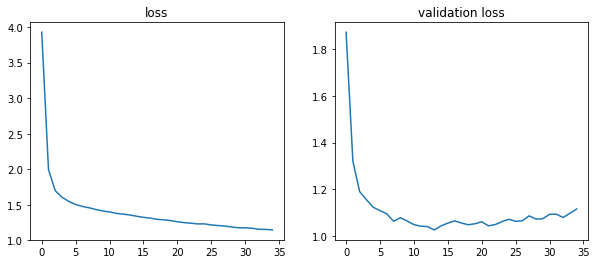

In [19]:
print("training History")
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
plt.plot(model.history.history['loss'])
ax1.set_title('loss')
ax2 = fig.add_subplot(1, 2, 2)
plt.plot(model.history.history['val_loss'])
ax2.set_title('validation loss')

100%|██████████| 50000/50000 [22:48<00:00, 36.54it/s]


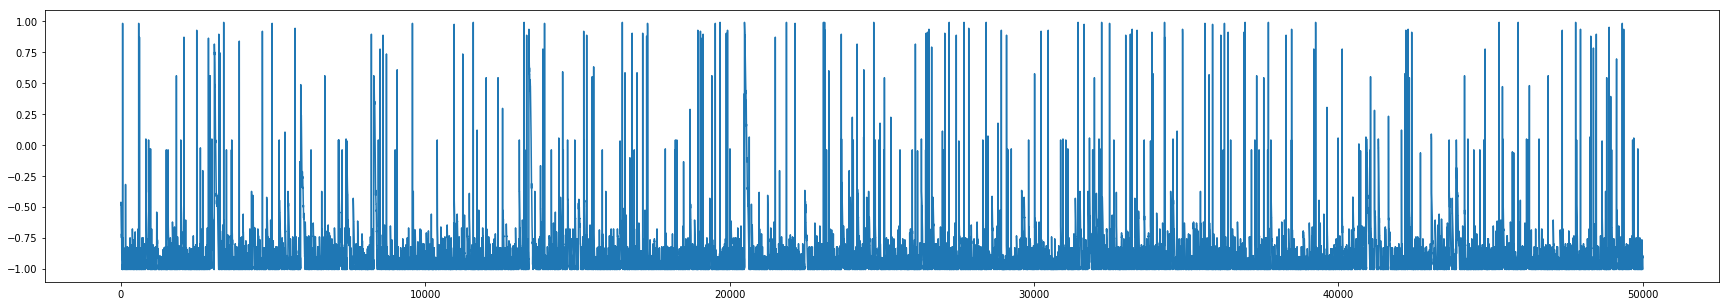

 13%|█▎        | 6342/50000 [02:59<20:33, 35.39it/s]

KeyboardInterrupt: 

 13%|█▎        | 6342/50000 [03:10<21:48, 33.37it/s]

In [20]:
from IPython.display import display

def sample(preds, temperature=1.0, min_value=0, max_value=1):
    #helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    v = np.argmax(probas)/float(probas.shape[1])
    return v * (max_value - min_value) + min_value

for start in range(50000, 300000, 100000):
    seq = y[start: maxlen]
    seq_matrix = np.zeros((maxlen, nb_output), dtype=bool)
    for i,s in enumerate(seq):
        sample_ = int(s * (nb_output - 1)) # 0-255
        seq_matrix[i, sample_] = True
    
    for i in tqdm(range(50000)):
        z = model.predict(seq_matrix.reshape((1, maxlen, nb_output)))
        s = sample(z[0], 1.0)
        seq = np.append(seq, s)
        
        sample_ = int(s * (nb_output - 1))
        seq_vec = np.zeros(nb_output, dtype=bool)
        seq_vec [sample_] = True
        
        seq_matrix = np.vstack((seq_matrix, seq_vec))
        seq_matrix = seq_matrix[1:]
        
    # scale back
    seq = seq * (max_y - min_y) + min_y
    
    # plot
    plt.figure(figsize=(30,5))
    plt.plot(seq.transpose())
    plt.show()
    
    display(Audio(seq, rate=sample_rate))

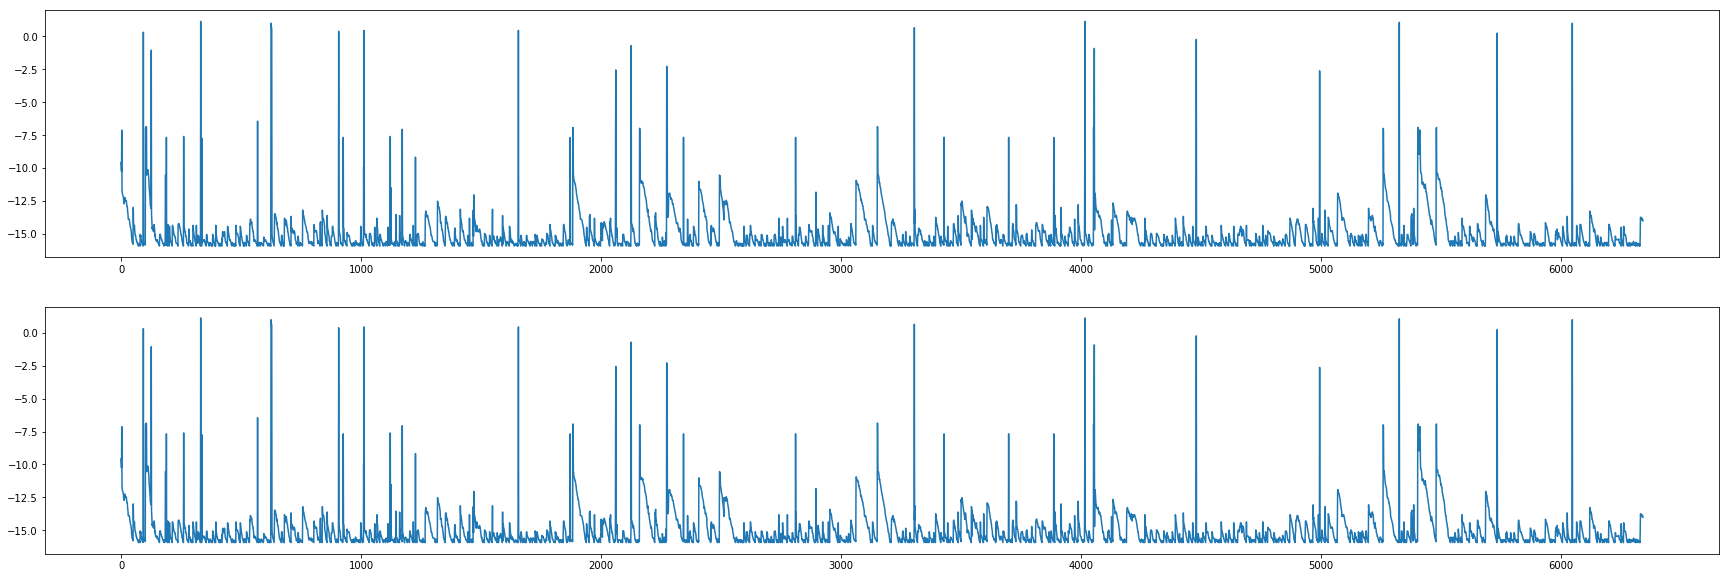

In [24]:
#scale back does this bit do anything?
seq = seq * (max_y - min_y) + min_y

# plot
fig = plt.figure(figsize=(30, 10))
ax1 = fig.add_subplot(2, 1, 1)
plt.plot(seq.transpose())

ax2 = fig.add_subplot(2, 1, 2)
plt.plot(seq[:30000].transpose())
plt.show()

display(Audio(seq, rate=sample_rate))